# Assignment 10: Conditional Generation & Guided Diffusion

Diffusion Model stolen from [here](https://medium.com/@vedantjumle/image-generation-with-diffusion-models-using-keras-and-tensorflow-9f60aae72ac)

## Imports

In [ ]:
!pip install tensorflow_addons
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from PIL import Image

import tensorflow as tf
from tensorflow import keras, einsum
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import ReLU
import tensorflow.keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

# from einops import rearrange
# from einops.layers.tensorflow import Rearrange
from functools import partial
from inspect import isfunction

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

## Get Dataset

In [ ]:
# set the parameters for dataset
target_size = (32, 32)
channels = 1
BATCH_SIZE = 256

# Normalization helper
def preprocess(x, y):
    return tf.image.resize(tf.cast(x, tf.float32) / 127.5 - 1, (32, 32))

def get_datasets():
    # Load the MNIST dataset
    train_ds = tfds.load('mnist', as_supervised=True, split="train")

    # Normalize to [-1, 1], shuffle and batch
    train_ds = train_ds.map(preprocess, tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Return numpy arrays instead of TF tensors while iterating
    return tfds.as_numpy(train_ds)


dataset = get_datasets()

For Class-Conditioned:

In [ ]:
# set the parameters for dataset
target_size = (32, 32)
channels = 1
BATCH_SIZE = 128

# Normalization helper
def preprocess(x, y):
    return tf.image.resize(tf.cast(x, tf.float32) / 127.5 - 1, (32, 32)), tf.cast(y, tf.int32)

# Load the MNIST dataset
dataset = tfds.load('mnist', as_supervised=True, split="train")

# Normalize to [-1, 1], shuffle and batch
dataset = dataset.map(preprocess, tf.data.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Parameters

In [ ]:
timesteps = 500

# create a fixed beta schedule
beta = np.linspace(0.0001, 0.02, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)

# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size=x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return tf.random.uniform(shape=[num], minval=0, maxval=timesteps, dtype=tf.int32)

## Forward Process example

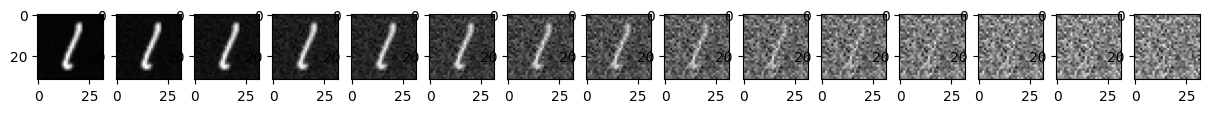

In [ ]:
# Let us visualize the output image at a few timestamps
sample_mnist = next(iter(dataset))[0]

fig = plt.figure(figsize=(15, 30))

for index, i in enumerate([2, 5, 10, 20, 30, 50, 75, 100, 150, 199, 250, 299, 350, 400, 499]):
    noisy_im, noise = forward_noise(0, np.expand_dims(sample_mnist, 0), np.array([i,]))
    plt.subplot(1, 15, index+1)
    plt.imshow(np.squeeze(np.squeeze(noisy_im, -1), 0), cmap='gray')


plt.show()

## Helper functions

In [ ]:
# helpers functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# We will use this to convert timestamps to time encodings
class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions=10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training=True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

        return emb

# small helper modules
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training=True):
        return tf.identity(x)


class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(x, training=training) + x

def Upsample(dim):
    return nn.Conv2DTranspose(filters=dim, kernel_size=4, strides=2, padding='SAME')

def Downsample(dim):
    return nn.Conv2D(filters=dim, kernel_size=4, strides=2, padding='SAME')

class LayerNorm(Layer):
    def __init__(self, dim, eps=1e-5, **kwargs):
        super(LayerNorm, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, 1, 1, dim]))
        self.b = tf.Variable(tf.zeros([1, 1, 1, dim]))

    def call(self, x, training=True):
        var = tf.math.reduce_variance(x, axis=-1, keepdims=True)
        mean = tf.reduce_mean(x, axis=-1, keepdims=True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x

In [ ]:
# building block modules
class Block(Layer):
    def __init__(self, dim, groups=8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size=3, strides=1, padding='SAME')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon=1e-05)
        self.act = ReLU()


    def call(self, x, gamma_beta=None, training=True):
        x = self.proj(x)
        x = self.norm(x, training=training)

        if exists(gamma_beta):
            gamma, beta = gamma_beta
            x = x * (gamma + 1) + beta

        x = self.act(x)
        return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim=None, groups=8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            ReLU(),
            nn.Dense(units=dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups=groups)
        self.block2 = Block(dim_out, groups=groups)
        self.res_conv = nn.Conv2D(filters=dim_out, kernel_size=1, strides=1) if dim != dim_out else Identity()

    def call(self, x, time_emb=None, training=True):
        gamma_beta = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b 1 1 c')
            gamma_beta = tf.split(time_emb, num_or_size_splits=2, axis=-1)

        h = self.block1(x, gamma_beta=gamma_beta, training=training)
        h = self.block2(h, training=training)

        return h + self.res_conv(x)

class ClassConditioning(Layer):
    def __init__(self, res, num_channels=1):
        super().__init__()
        self.block = Sequential([
            nn.Dense(res * res * num_channels),
            ReLU(),
            nn.Reshape((res, res, num_channels))
        ])

        self.block.compile()

    def call(self, x):
        return self.block(x)

Standard:

In [ ]:
class Unet(Model):
    def __init__(self,
                 dim=64,
                 init_dim=None,
                 out_dim=None,
                 dim_mults=(1, 2, 4, 8),
                 channels=3,
                 resnet_block_groups=4,
                 learned_variance=False,
                 sinusoidal_cond_mlp=True
                 ):
        super(Unet, self).__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp

        self.time_mlp = Sequential([
            SinusoidalPosEmb(dim),
            nn.Dense(units=time_dim),
            ReLU(),
            nn.Dense(units=time_dim)
        ], name="time embeddings")

        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                Downsample(dim_out) if not is_last else Identity()
            ])

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                Upsample(dim_in) if not is_last else Identity()
            ])

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_conv = Sequential([
            block_klass(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ], name="output")

    def call(self, x, time=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)

        h = []

        for block1, block2, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_block2(x, t)

        for block1, block2, upsample in self.ups:
            x = tf.concat([x, h.pop()], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=-1)
        x = self.final_conv(x)
        return x

Conditional:

In [ ]:
class Unet_conditional(Model):
    def __init__(self,
                 dim=64,
                 init_dim=None,
                 out_dim=None,
                 dim_mults=(1, 2, 4, 8),
                 channels=3,
                 resnet_block_groups=4,
                 learned_variance=False,
                 sinusoidal_cond_mlp=True,
                 num_classes=None,
                 class_embedder=None,
                 class_emb_dim=64,
                 in_res=64
                 ):
        super(Unet_conditional, self).__init__()

        # determine dimensions
        self.channels = channels
        self.in_res = in_res

        self.class_embeddings = nn.Embedding(num_classes, class_emb_dim) if class_embedder is None else class_embedder

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp

        if sinusoidal_cond_mlp:
            self.time_mlp = Sequential([
                SinusoidalPosEmb(dim),
                nn.Dense(units=time_dim),
                ReLU(),
                nn.Dense(units=time_dim)
            ], name="time embeddings")
        else:
            self.time_mlp = MLP(time_dim)

        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)

        now_res = in_res

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                ClassConditioning(now_res),
                block_klass(dim_in+1, dim_out, time_emb_dim=time_dim),
                block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                Downsample(dim_out) if not is_last else Identity()
            ])

            now_res //= 2 if not is_last else 1

        mid_dim = dims[-1]
        self.mid_class_conditioning = ClassConditioning(now_res)
        self.mid_block1 = block_klass(mid_dim+1, mid_dim, time_emb_dim=time_dim)
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                ClassConditioning(now_res),
                block_klass((dim_out * 2) + 1, dim_in, time_emb_dim=time_dim),
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                Upsample(dim_in) if not is_last else Identity()
            ])

            now_res *= 2 if not is_last else 1

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_conv = Sequential([
            block_klass(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ], name="output")

    def call(self, x, time=None, class_vector=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)

        class_vector = self.class_embeddings(class_vector)

        h = []

        for class_conditioning, block1, block2, downsample in self.downs:
            cv = class_conditioning(class_vector)
            x = tf.concat([x, cv], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            h.append(x)
            x = downsample(x)

        cv = self.mid_class_conditioning(class_vector)
        x = tf.concat([x, cv], axis=-1)
        x = self.mid_block1(x, t)
        x = self.mid_block2(x, t)

        for class_conditioning, block1, block2, upsample in self.ups:
            cv = class_conditioning(class_vector)
            x = tf.concat([x, cv], axis=-1)
            x = tf.concat([x, h.pop()], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=-1)
        x = self.final_conv(x)
        return x

In [ ]:
unet = Unet(channels=1)

test_images = np.ones([1, 32, 32, 1])
test_timestamps = generate_timestamp(0, 1)
k = unet(test_images, test_timestamps)

opt = keras.optimizers.Adam()

In [ ]:
unet = Unet_conditional(
    num_classes=10,
    in_res=32,
    channels=1
)

test_images = np.ones([1, 32, 32, 1])
test_timestamps = generate_timestamp(0, 1)

test_class = np.array([3], dtype=np.int32)

k = unet(test_images, test_timestamps, test_class)

opt = keras.optimizers.Adam()

In [ ]:
def loss_fn(real, generated):
    loss = tf.math.reduce_mean((real - generated) ** 2)
    return loss

In [ ]:
rng = 0

Standard:

In [ ]:
def train_step(batch):
    rng, tsrng = np.random.randint(0, 100000, size=(2,))
    timestep_values = generate_timestamp(tsrng, batch.shape[0])

    noised_image, noise = forward_noise(rng, batch, timestep_values)
    with tf.GradientTape() as tape:
        prediction = unet(noised_image, timestep_values)

        loss_value = loss_fn(noise, prediction)

    gradients = tape.gradient(loss_value, unet.trainable_variables)
    opt.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

Conditional:

In [ ]:
def train_step(batch, _class):
    rng, tsrng = np.random.randint(0, 100000, size=(2,))
    timestep_values = generate_timestamp(tsrng, batch.shape[0])

    noised_image, noise = forward_noise(rng, batch, tf.cast(timestep_values, tf.int32))
    with tf.GradientTape() as tape:
        prediction = unet(noised_image, timestep_values, _class)

        loss_value = loss_fn(noise, prediction)

    gradients = tape.gradient(loss_value, unet.trainable_variables)
    opt.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

Standard:

In [ ]:
epochs = 10
for e in range(1, epochs+1):

    # this is cool utility in Tensorflow that will create a nice looking progress bar
    bar = tf.keras.utils.Progbar(len(dataset)-1)

    losses = []

    for i, batch in enumerate(iter(dataset)):
        # run the training loop
        loss = train_step(batch)
        losses.append(loss)
        bar.update(i, values=[("loss", loss)])

    avg = np.mean(losses)

 23/234 [=>............................] - ETA: 2:56 - loss: 0.0423

KeyboardInterrupt: ignored

Conditional:

In [ ]:
epochs = 5
for e in range(1, epochs+1):
    bar = tf.keras.utils.Progbar(len(dataset)-1)
    losses = []
    for i, batch in enumerate(iter(dataset)):
        # run the training loop
        loss = train_step(batch[0], batch[1])
        losses.append(loss)
        bar.update(i, values=[("loss", loss)])

    avg = np.mean(losses)

468/468 [==============================] - 376s 723ms/step - loss: 0.3027
Average loss for epoch 1/5: 0.3026634752750397
468/468 [==============================] - 338s 720ms/step - loss: 0.0862
Average loss for epoch 2/5: 0.08618184924125671
119/468 [======>.......................] - ETA: 4:17 - loss: 0.0685

KeyboardInterrupt: ignored

In [ ]:
def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t)
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

  0%|          | 0/499 [00:00<?, ?it/s]

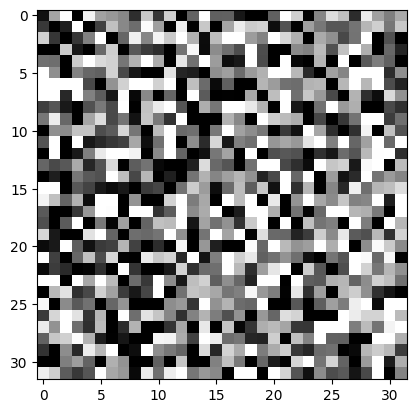

  5%|▌         | 25/499 [00:05<01:38,  4.83it/s]

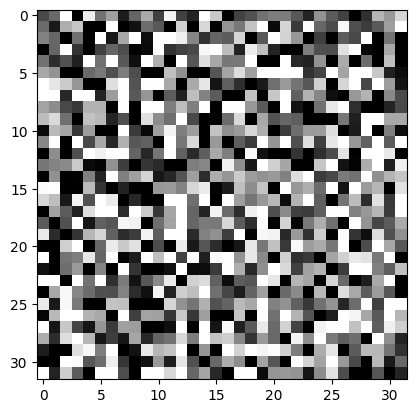

 10%|█         | 50/499 [00:11<01:32,  4.85it/s]

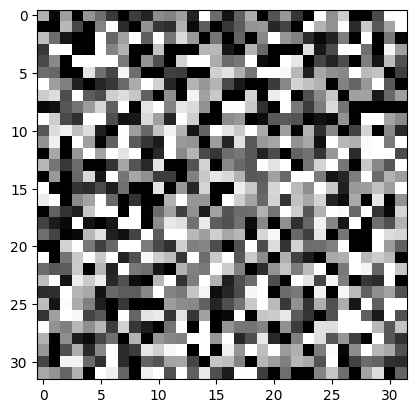

 15%|█▌        | 75/499 [00:16<01:27,  4.82it/s]

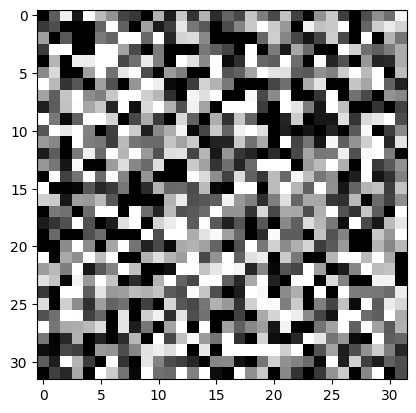

 20%|██        | 100/499 [00:22<01:23,  4.79it/s]

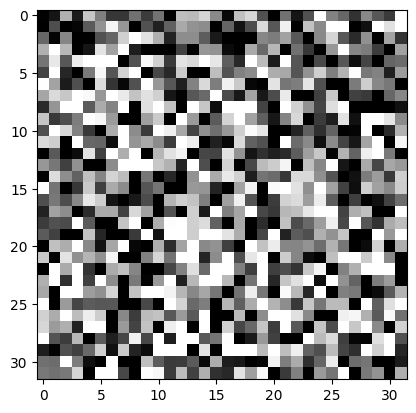

 25%|██▌       | 125/499 [00:27<01:21,  4.61it/s]

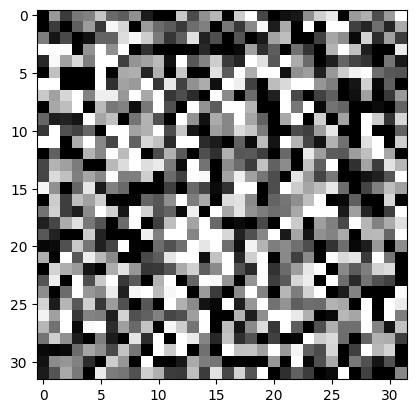

 30%|███       | 150/499 [00:33<01:13,  4.77it/s]

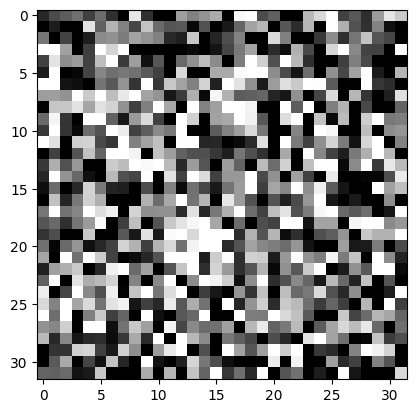

 35%|███▌      | 175/499 [00:39<01:11,  4.55it/s]

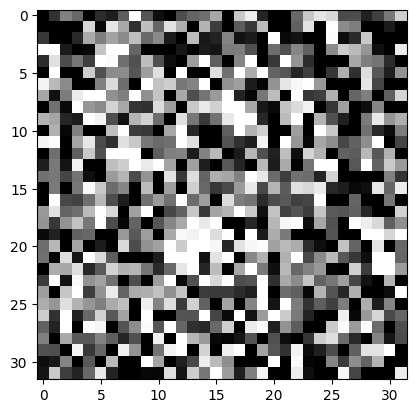

 40%|████      | 200/499 [00:44<01:02,  4.75it/s]

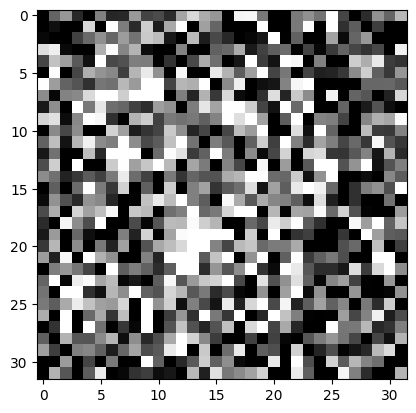

 45%|████▌     | 225/499 [00:50<00:59,  4.60it/s]

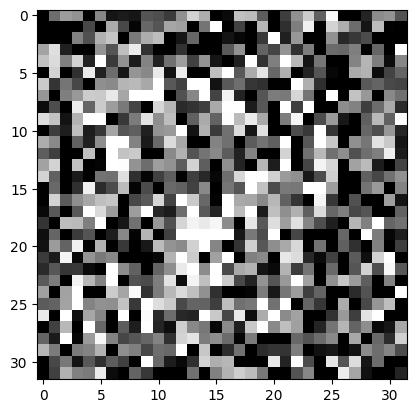

 50%|█████     | 250/499 [00:56<00:52,  4.73it/s]

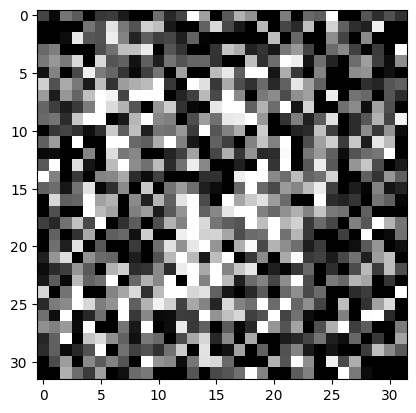

 55%|█████▌    | 275/499 [01:01<00:50,  4.47it/s]

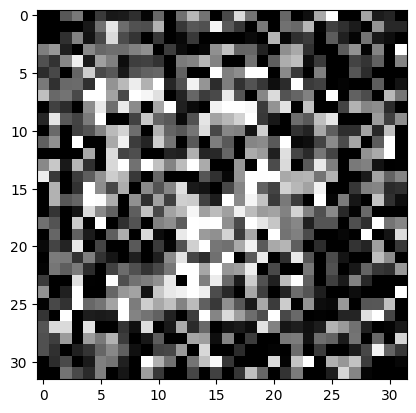

 60%|██████    | 300/499 [01:07<00:42,  4.71it/s]

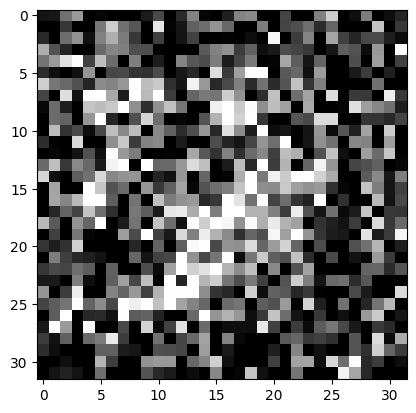

 65%|██████▌   | 325/499 [01:13<00:38,  4.55it/s]

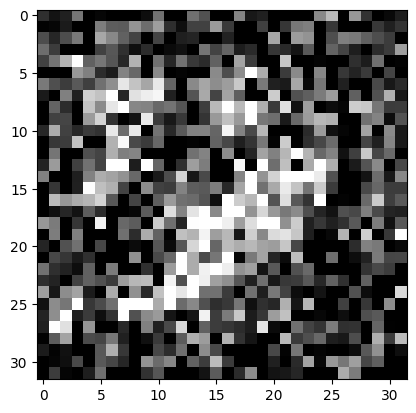

 70%|███████   | 350/499 [01:18<00:30,  4.81it/s]

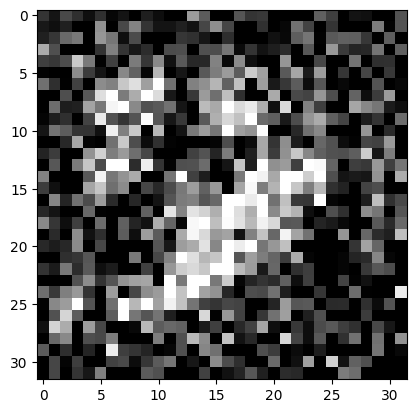

 75%|███████▌  | 375/499 [01:24<00:28,  4.29it/s]

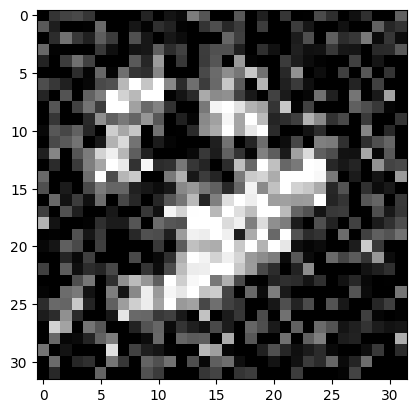

 80%|████████  | 400/499 [01:30<00:20,  4.76it/s]

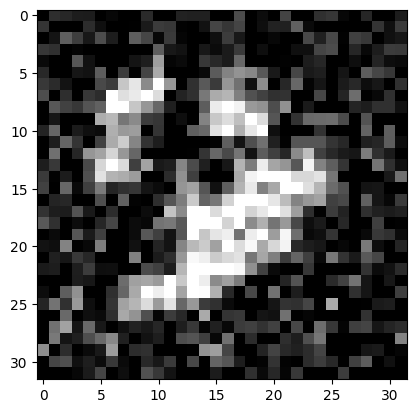

 85%|████████▌ | 425/499 [01:35<00:16,  4.44it/s]

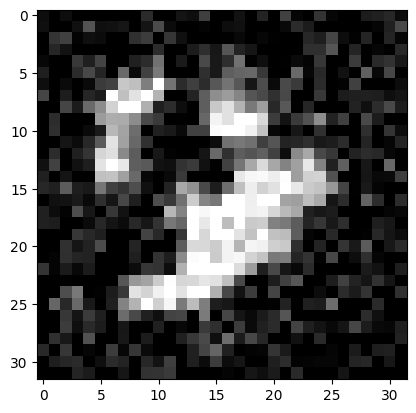

 90%|█████████ | 450/499 [01:41<00:10,  4.79it/s]

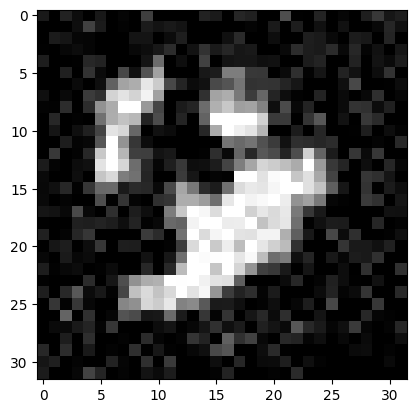

 95%|█████████▌| 475/499 [01:46<00:05,  4.09it/s]

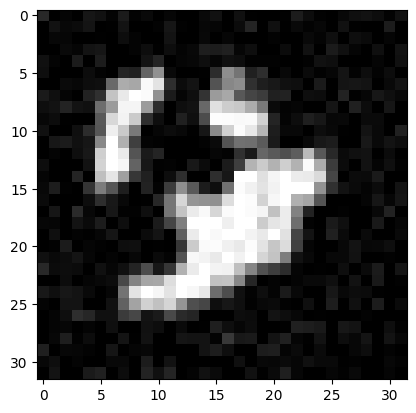

100%|██████████| 499/499 [01:52<00:00,  4.45it/s]


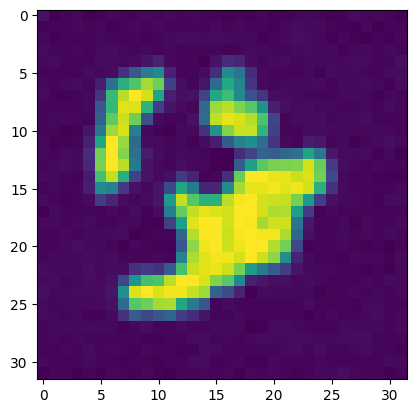

In [ ]:
x = tf.random.normal((1,32,32,1))
img_list = []
img_list.append(np.squeeze(np.squeeze(x, 0),-1))

for i in tqdm(range(timesteps-1)):
    t = np.expand_dims(np.array(timesteps-i-1, np.int32), 0)
    pred_noise = unet(x, t)
    x = ddpm(x, pred_noise, t)
    img_list.append(np.squeeze(np.squeeze(x, 0),-1))

    if i % 25==0:
        plt.imshow(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8), cmap="gray")
        plt.show()

plt.imshow(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8))
plt.show()

  0%|          | 0/499 [00:00<?, ?it/s]

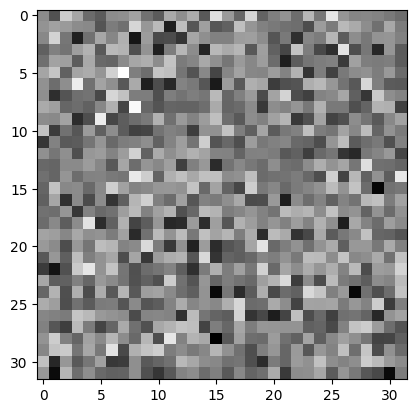

  5%|▌         | 25/499 [00:06<01:50,  4.28it/s]

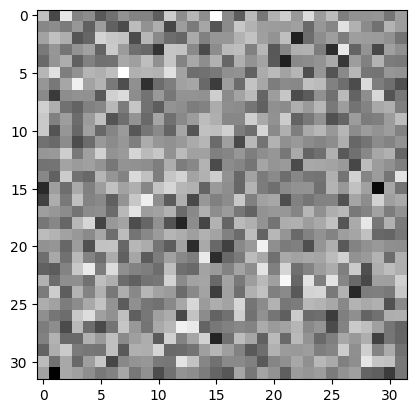

 10%|█         | 50/499 [00:12<01:44,  4.28it/s]

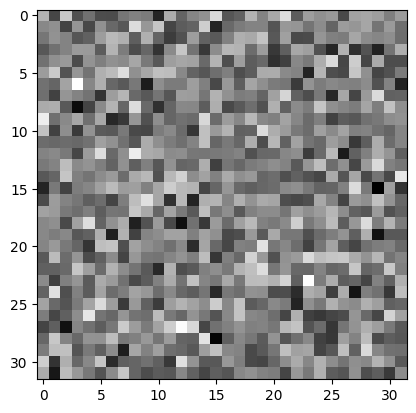

 15%|█▌        | 75/499 [00:18<01:44,  4.07it/s]

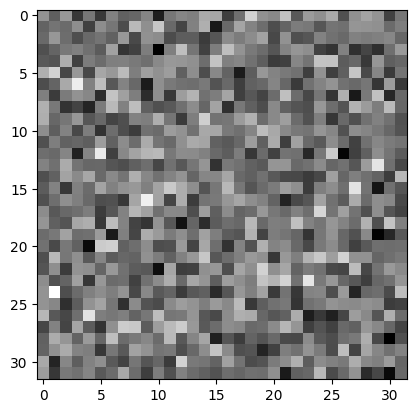

 20%|██        | 100/499 [00:25<01:34,  4.23it/s]

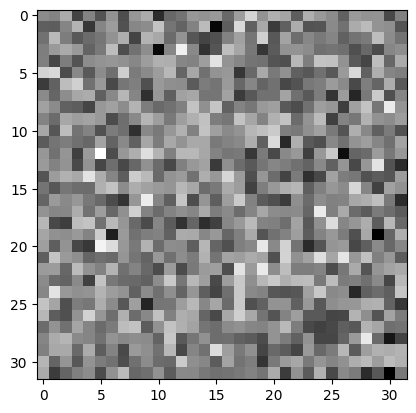

 25%|██▌       | 125/499 [00:31<01:47,  3.47it/s]

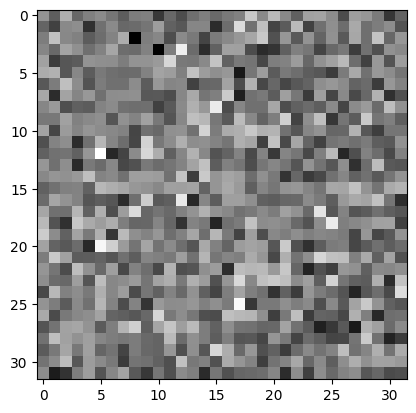

 30%|███       | 150/499 [00:38<01:23,  4.15it/s]

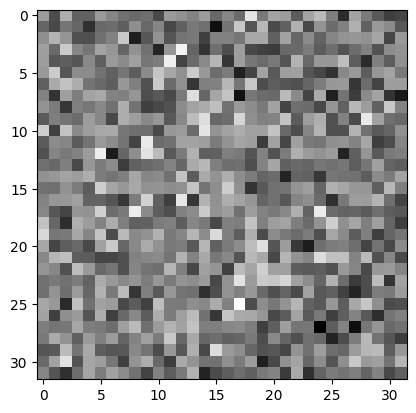

 35%|███▌      | 175/499 [00:44<01:19,  4.10it/s]

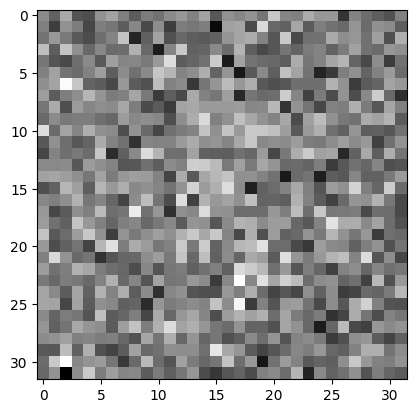

 40%|████      | 200/499 [00:50<01:12,  4.13it/s]

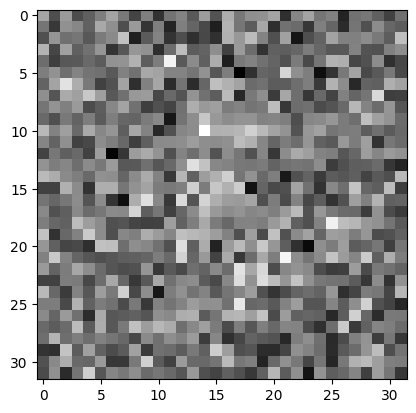

 45%|████▌     | 225/499 [00:57<01:05,  4.18it/s]

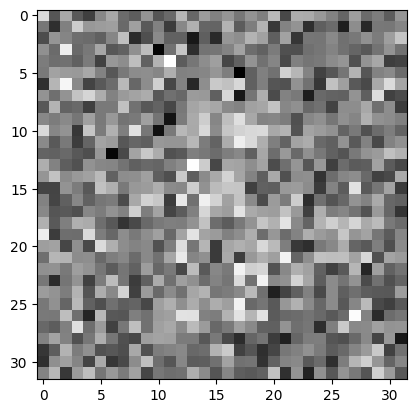

 50%|█████     | 250/499 [01:03<00:59,  4.18it/s]

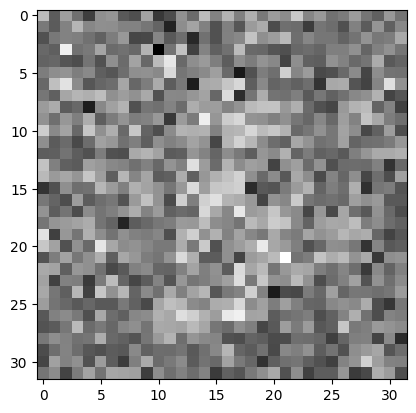

 55%|█████▌    | 275/499 [01:10<00:53,  4.18it/s]

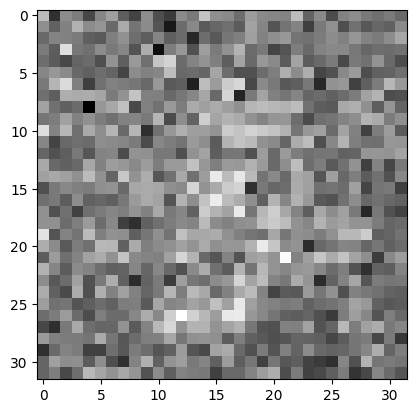

 60%|██████    | 300/499 [01:16<00:51,  3.88it/s]

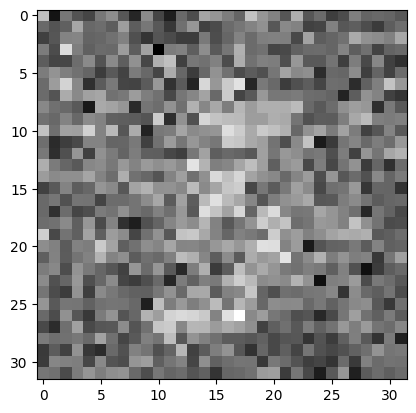

 65%|██████▌   | 325/499 [01:22<00:42,  4.10it/s]

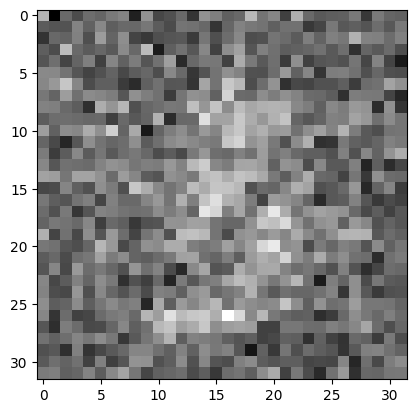

 70%|███████   | 350/499 [01:29<00:44,  3.37it/s]

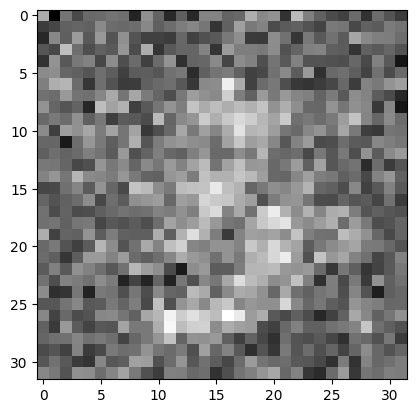

 75%|███████▌  | 375/499 [01:35<00:28,  4.29it/s]

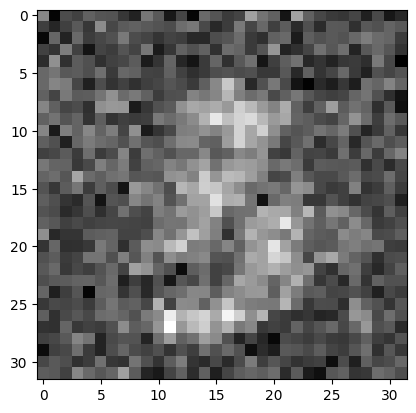

 80%|████████  | 400/499 [01:41<00:24,  4.05it/s]

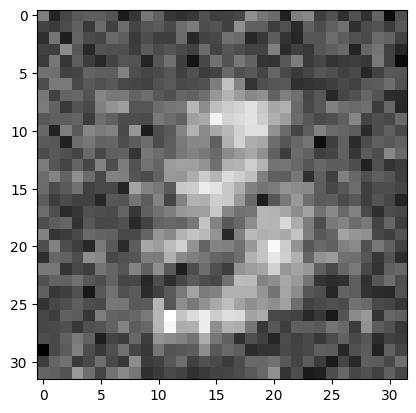

 85%|████████▌ | 425/499 [01:47<00:17,  4.30it/s]

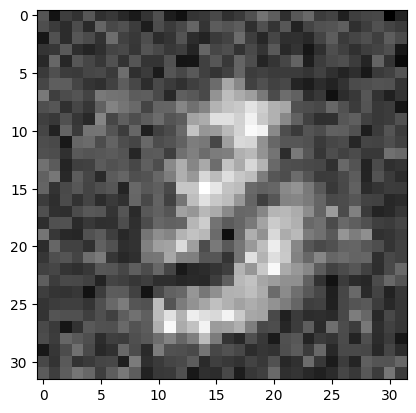

 90%|█████████ | 450/499 [01:54<00:11,  4.22it/s]

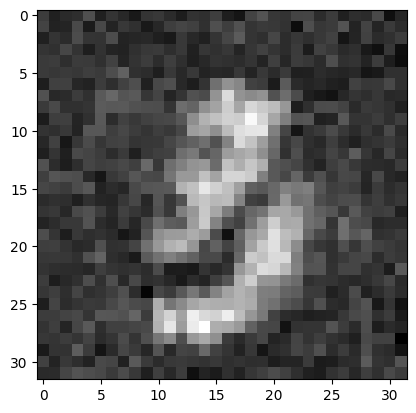

 95%|█████████▌| 475/499 [02:00<00:05,  4.14it/s]

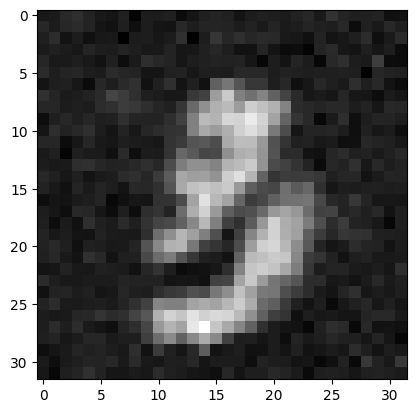

100%|██████████| 499/499 [02:06<00:00,  3.94it/s]


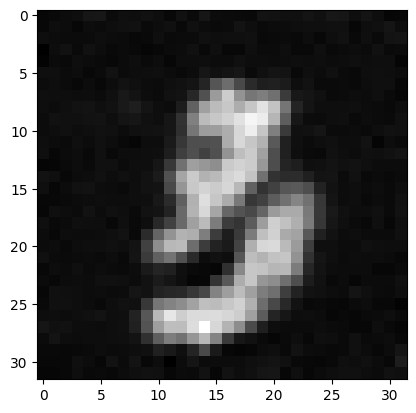

In [ ]:
x = tf.random.normal((1,32,32,1))

img_list = []
img_list.append(np.squeeze(np.squeeze(x, 0), -1))

_class = 3

for i in tqdm(range(timesteps-1)):
    t = np.expand_dims(np.array(timesteps-i-1, np.int32), 0)
    pred_noise = unet(x, t, np.array([_class], dtype=np.int32))
    x = ddpm(x, pred_noise, t)
    img_list.append(np.squeeze(np.squeeze(x, 0), -1))

    if i % 25==0:

        plt.imshow(x[0], cmap='gray')
        plt.show()

plt.imshow(x[0], cmap='gray')
plt.show()